In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from PULS.evaluation import evaluate_shifted_pi_estimation, evaluate_shifted_pi_estimation_from_all_data, evaluate_all_TC_metrics, evaluate_all_TC_metrics_from_all_data


In [2]:
def plot_mae_with_se(df, pi_grid, label_frequency, verbose=False):
    """Plot Mean Absolute Error (MAE) with Standard Error (SE) for different methods across varying train and test priors."""
    df = df.sort_values(['pi', 'new_pi'])
    sns.set_theme(style="whitegrid")
    g = sns.FacetGrid(df, col="pi", col_wrap=2, height=4, sharey=True)

    def plot_with_std(data, color, **kwargs):
        methods = data['method'].unique()
        for method in methods:
            sub = data[data['method'] == method]
            plt.plot(sub['new_pi'], sub['mae'], label=method, marker='o', linewidth=1, linestyle='-', markersize=5)
            plt.fill_between(
                sub['new_pi'],
                sub['mae'] - sub['se'],
                sub['mae'] + sub['se'],
                alpha=0.2
            )

    g.map_dataframe(plot_with_std)

    g.set(xticks=pi_grid)
    for ax in g.axes.flatten():
        ax.yaxis.grid(True, linestyle='--', alpha=0.7)
        ax.xaxis.grid(True, linestyle='--', alpha=0.7)

    if verbose:
        g.set_axis_labels("True test prior", "MAE")
        g.set_titles("Training prior = {col_name}")
        g.figure.suptitle(f"label frequency $= {label_frequency}$", fontsize=12, x=0.47)
    else:
        g.set_axis_labels("$\pi'$", "MAE")
        g.set_titles("$\pi$ = {col_name}")
        g.figure.suptitle(f"$c = {label_frequency}$", fontsize=12, x=0.47)
        
    plt.tight_layout()
    g.add_legend(title="Method", loc='center right')    
    plt.show()

    

# def plot_mae_without_se(df, pi_grid, label_frequency):
#     df = df.sort_values(['pi', 'new_pi'])

#     sns.set_theme(style="whitegrid")
#     g = sns.FacetGrid(df, col="pi", col_wrap=2, height=4, sharey=True)

#     def plot_lineplots(data, color, **kwargs):
#         sns.lineplot(
#             data=data,
#             x="new_pi",
#             y="mae",
#             hue="method",
#             marker="o",
#             markersize=6,
#             linestyle="-",
#             linewidth=1,
#             ax=plt.gca()
#         )

#     g.map_dataframe(plot_lineplots)
#     g.set(xticks=[0.2, 0.4, 0.6, 0.8])
#     for ax in g.axes.flatten():
#         ax.yaxis.grid(True, linestyle='--')
#         ax.xaxis.grid(True, linestyle='--')

#     g.set_axis_labels("True test prior", "Mean Absolute Error")
#     g.set_titles("Training prior = {col_name}")
#     plt.tight_layout()
#     g.add_legend(title="Method", loc='center right')
#     plt.show()


def plot_metric(df, metric, pi_grid, label_frequency, verbose=False):
    """Plot a given metric for different methods across varying train and test priors."""
    df = df.sort_values(['pi', 'new_pi'])
    sns.set_theme(style="whitegrid")
    g = sns.FacetGrid(df, col="pi", col_wrap=2, height=4, sharey=True)
    palette = sns.color_palette('tab20', n_colors=df['model-method'].nunique())

    def plot_lineplots(data, color, **kwargs):
        sns.lineplot(
            data=data,
            x="new_pi",
            y="average_value",
            hue="model-method",
            marker="o",
            markersize=6,
            linestyle="-",
            linewidth=1,
            ax=plt.gca(),
            palette=palette
        )

    g.map_dataframe(plot_lineplots)
    g.set(xticks=pi_grid)
    for ax in g.axes.flatten():
        ax.yaxis.grid(True, linestyle='--')
        ax.xaxis.grid(True, linestyle='--')

    if verbose:
        g.set_axis_labels("True test prior", f"Average {metric}")
        g.set_titles("Training prior = {col_name}")
        g.figure.suptitle(f"label frequency = {label_frequency}", fontsize=12, x=0.47)
    else:
        g.set_axis_labels("$\pi'$", f"Average {metric}")
        g.set_titles("$\pi$ = {col_name}")
        g.figure.suptitle(f"$c = {label_frequency}$", fontsize=12, x=0.47)

    plt.tight_layout()
    g.add_legend(title="Model + Method", loc='center right')
    plt.show()


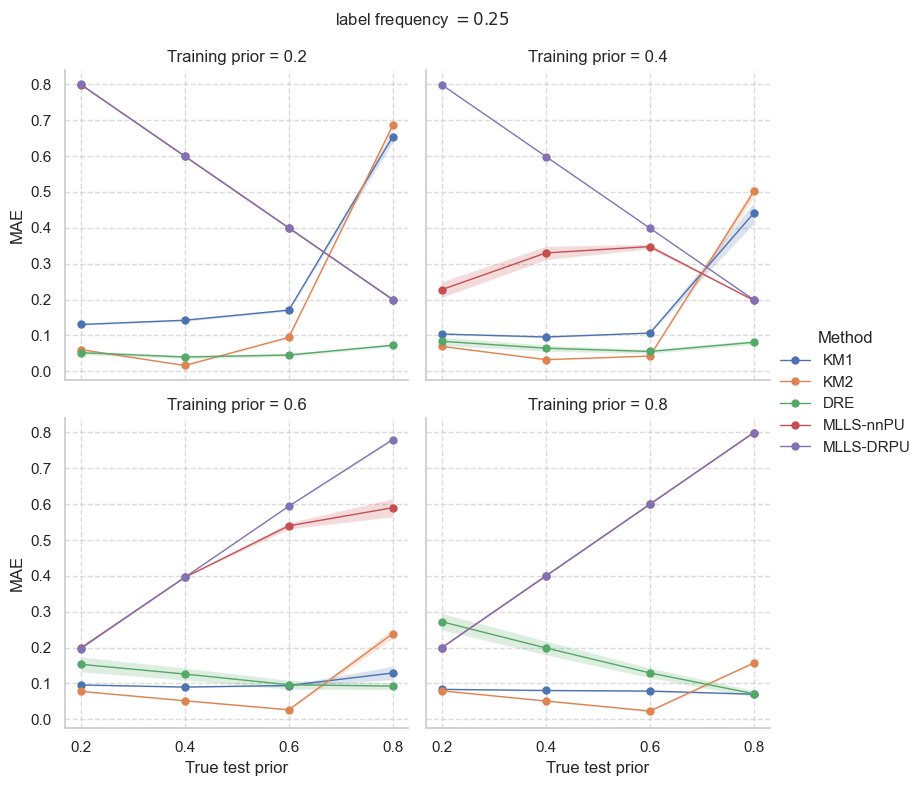

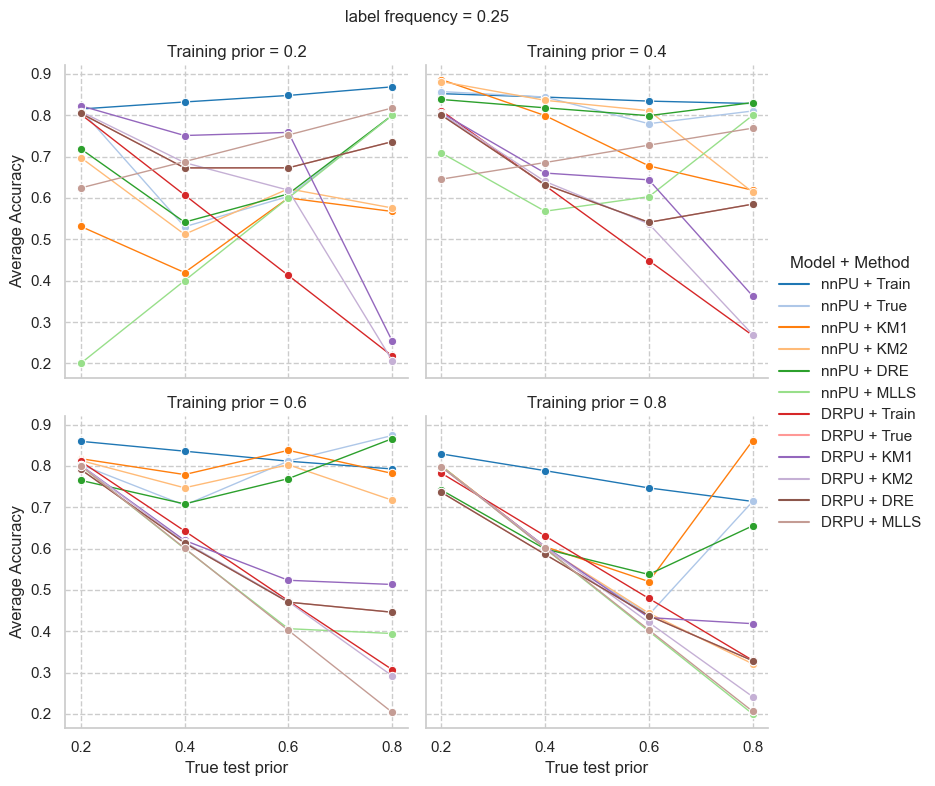

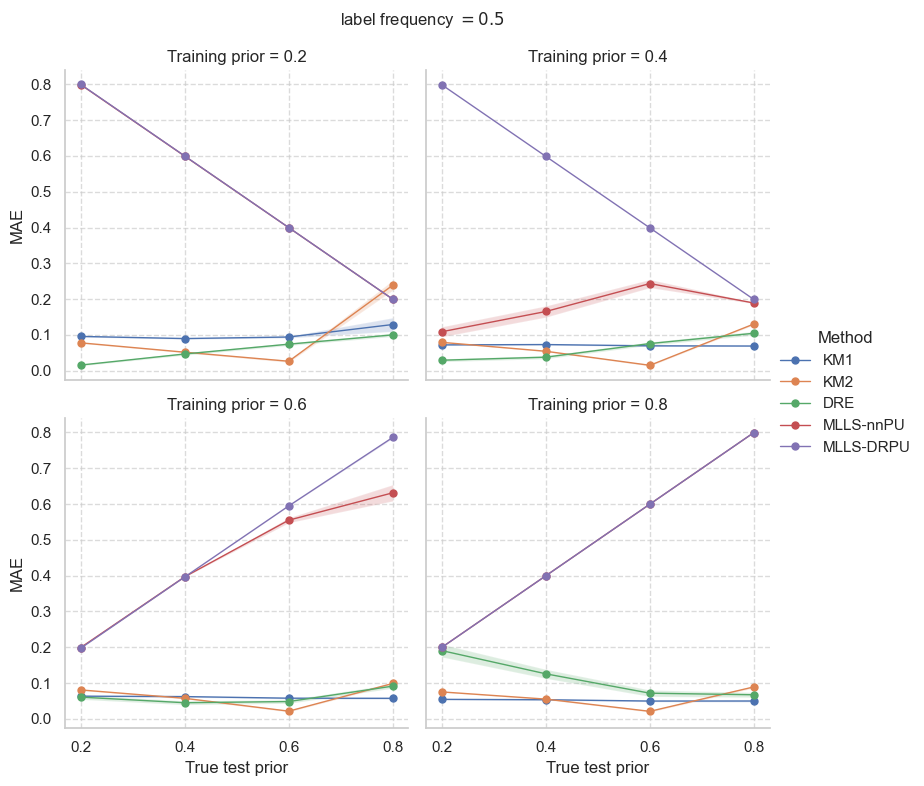

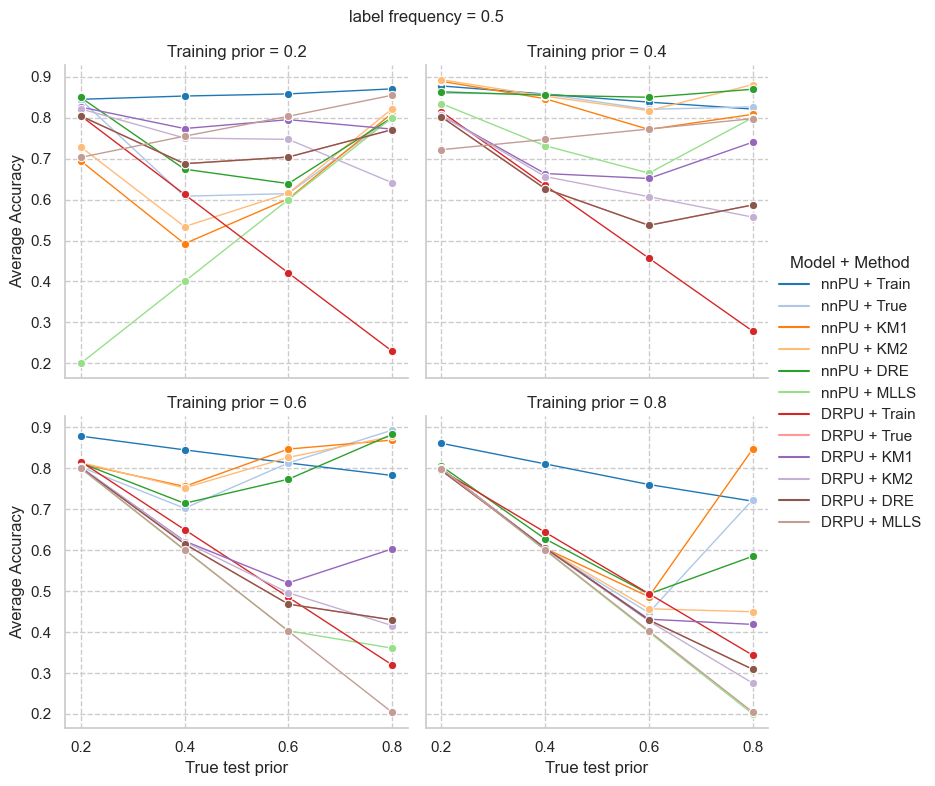

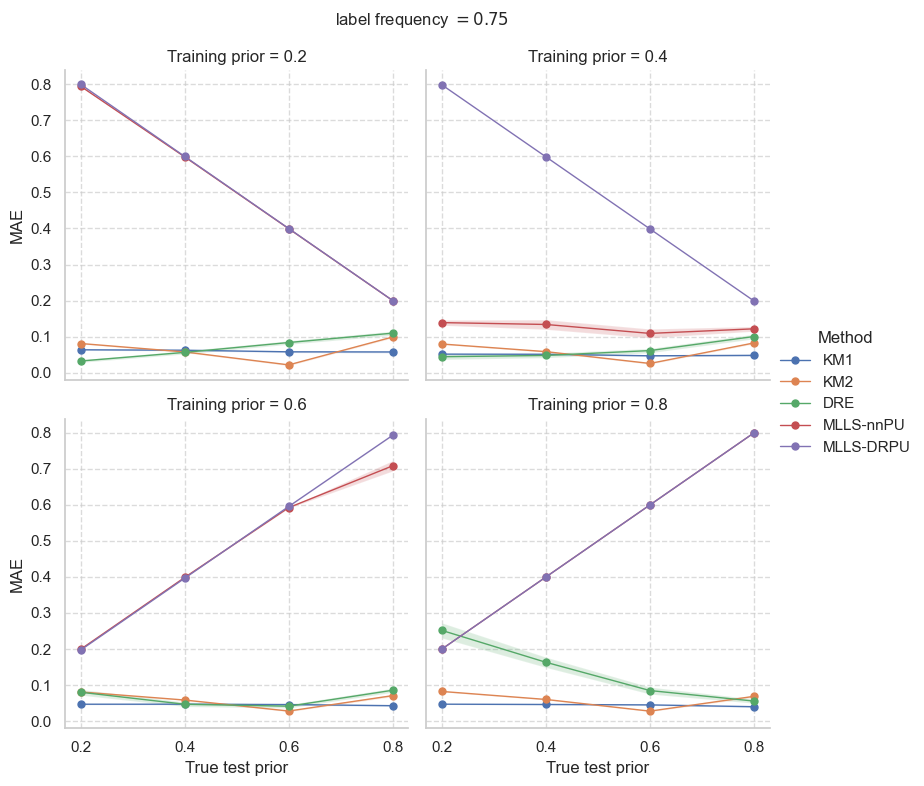

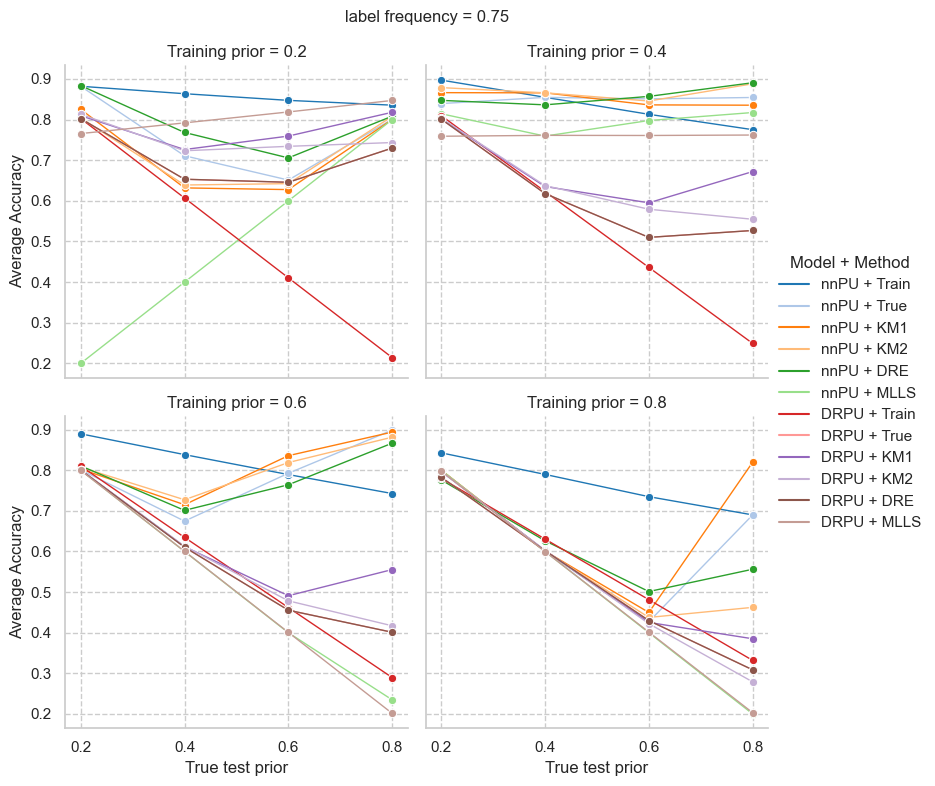

In [3]:
# Mean Absolute Error of test prior estimation for Gaussian Dataset (n = n′ = 1000, K = 10)
# Average Accuracy of different trained classifiers for Gaussian Dataset (n = n′ = 1000, K = 10)

dataset_name = 'Gauss'
mean = 0.5
n = 1000
label_frequencies = [0.25, 0.5, 0.75]
pi_grid = [0.2, 0.4, 0.6, 0.8]

method_mapping = {"DR": "DRE", "DRE": "DRE", "KM1": "KM1", "KM2": "KM2", "MLLS_DRPU": "MLLS-DRPU", "MLLS_NNPU": "MLLS-nnPU", "mlls-drpu": "MLLS", "mlls-nnpu": "MLLS", "train": "Train", "true": "True"}
model_mapping = {"drpu": "DRPU", "nnpu": "nnPU"}

for label_frequency in label_frequencies:
        df_mae = evaluate_shifted_pi_estimation(dataset_name, mean, n, label_frequency, pi_grid, pi_grid, convert_to_df=True)
        df_mae["value"] = round(df_mae['mae'], 3).astype(str) + ' +- ' + round(df_mae['std_mae'], 3).astype(str)
        df_mae['method'] = df_mae['method'].map(method_mapping)
        plot_mae_with_se(df_mae, pi_grid, label_frequency, verbose=True)

        df_metric = evaluate_all_TC_metrics(dataset_name, mean, n, label_frequency, pi_grid, pi_grid, convert_to_df=True)
        df_metric = df_metric[df_metric['metric'].isin(['accuracy'])]

        # filter out model = 'nnpu' and method = 'mlls-drpu' or model = 'drpu' and method = 'mlls-nnpu'
        df_metric = df_metric[~((df_metric['model'] == 'nnpu') & (df_metric['method'] == 'mlls-drpu')) & ~((df_metric['model'] == 'drpu') & (df_metric['method'] == 'mlls-nnpu'))]

        df_metric['model'] = df_metric['model'].map(model_mapping)
        df_metric['method'] = df_metric['method'].map(method_mapping)
        df_metric['model-method'] = df_metric['model'] + ' + ' + df_metric['method']
        plot_metric(df_metric, 'Accuracy', pi_grid, label_frequency, verbose=True)


# mae_results = df[["pi", "new_pi", "method", "value"]]
# mae_results = mae_results.pivot(index=["pi", "new_pi"], columns="method", values="value")

## MNIST

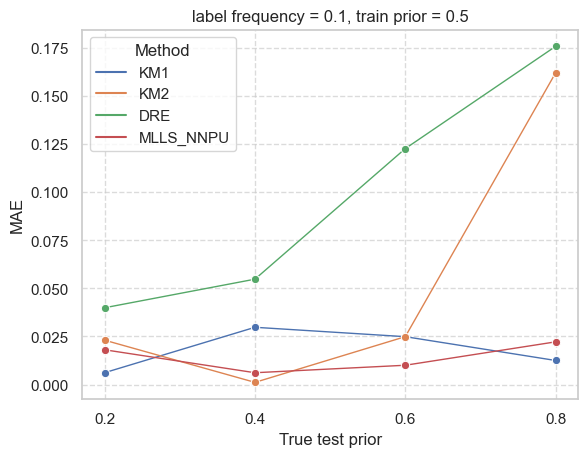

In [4]:
dataset_name = 'MNIST'
n = 50_000
label_frequency = 0.1
train_pi = [0.5]
test_pi = [0.2, 0.4, 0.6, 0.8]

df = evaluate_shifted_pi_estimation(dataset_name, None, n, label_frequency, train_pi, test_pi, convert_to_df=True, single_exp=True)
df['mae'] = abs(df['estimated_test_pi'] - df['new_pi'])
# df.pivot(index=["pi", "new_pi"], columns="method", values="mae")

df = df[~(df['method'].isin(['MLLS_DRPU']))]

sns.set_theme(style="whitegrid")
sns.lineplot(
    data=df,
    x="new_pi",
    y="mae",
    hue="method",
    marker="o",
    markersize=6,
    linestyle="-",
    linewidth=1,
)
plt.xticks(test_pi)
plt.xlabel("True test prior")
plt.ylabel("MAE")
plt.title(f"label frequency = {label_frequency}, train prior = 0.5")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Method", loc='upper left')
plt.show()


In [21]:
dataset_name = 'MNIST'
n = 50_000
label_frequency = 0.1
train_pi = [0.5]
test_pi = [0.2, 0.4, 0.6, 0.8]

df = evaluate_all_TC_metrics(dataset_name, None, n, label_frequency, train_pi, test_pi, convert_to_df=True, single_exp=True)
df = df[df['metric'].isin(['accuracy'])]

# filter out model = 'nnpu' and method = 'mlls-drpu' or model = 'drpu' and method = 'mlls-nnpu'
df = df[~((df['model'] == 'nnpu') & (df['method'] == 'mlls-drpu')) & ~((df['model'] == 'drpu') & (df['method'] == 'mlls-nnpu'))]

model_mapping = {"drpu": "DRPU", "nnpu": "nnPU"}
method_mapping = {"DR": "DRE", "KM1": "KM1", "KM2": "KM2", "mlls-drpu": "MLLS", "mlls-nnpu": "MLLS", "train": "Train", "true": "True"}
df['model'] = df['model'].map(model_mapping)
df['method'] = df['method'].map(method_mapping)
df['model-method'] = df['model'] + ' + ' + df['method']
df.pivot(index=["pi", "new_pi"], columns="model-method", values="average_value")

model-method  DRPU + DRE  DRPU + KM1  DRPU + KM2  DRPU + MLLS  DRPU + Train   
pi  new_pi                                                                    
0.5 0.2           0.9634      0.9730      0.9712       0.7068        0.8836  \
    0.4           0.9522      0.9460      0.9388       0.7780        0.9080   
    0.6           0.9400      0.9208      0.9208       0.8502        0.9348   
    0.8           0.9526      0.9388      0.9506       0.9268        0.9648   

model-method  DRPU + True  nnPU + DRE  nnPU + KM1  nnPU + KM2  nnPU + MLLS   
pi  new_pi                                                                   
0.5 0.2            0.9634      0.9628      0.9656      0.9658       0.9644  \
    0.4            0.9522      0.9488      0.9482      0.9492       0.9486   
    0.6            0.9400      0.9466      0.9492      0.9492       0.9502   
    0.8            0.9526      0.9542      0.9590      0.9554       0.9578   

model-method  nnPU + Train  nnPU + True  
pi  new_pi                               
0.5 0.2             0.9574       0.9654  
    0.4             0.9508       0.9490  
    0.6             0.9468       0.9500  
    0.8             0.9408       0.9578

C:\Users\izate\AppData\Local\Temp\ipykernel_1184120\3782312413.py:11: UserWarning: The palette list has more values (20) than needed (11), which may not be intended.
  sns.lineplot(


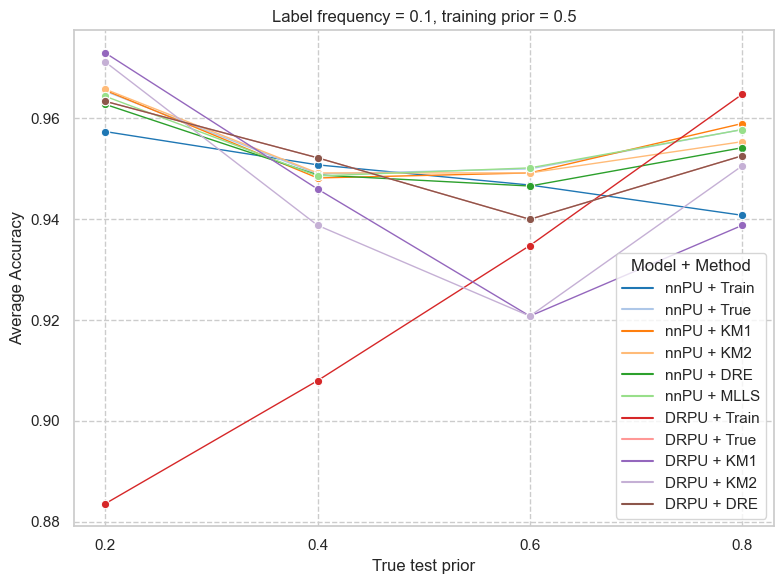

In [22]:
# filter out MLLS
df = df[~df['model-method'].str.contains('DRPU \+ MLLS')]

# MAE of test prior estimates for different training priors
df = df.sort_values(['pi', 'new_pi'])

fig = plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab20")

sns.lineplot(
    data=df,
    x="new_pi",
    y="average_value",
    hue="model-method",
    marker="o",
    markersize=6,
    linestyle="-",
    linewidth=1,
    ax=plt.gca(),
    palette=palette
)

plt.xticks([0.2, 0.4, 0.6, 0.8])
plt.gca().yaxis.grid(True, linestyle='--')
plt.gca().xaxis.grid(True, linestyle='--')

plt.xlabel("True test prior")
plt.ylabel("Average Accuracy")
plt.title("Label frequency = 0.1, training prior = 0.5")
plt.tight_layout()
plt.legend(title="Model + Method", loc='lower right')
plt.show()


## FashionMNIST

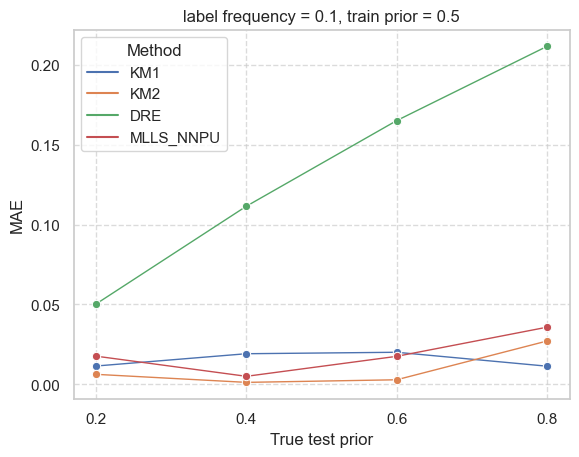

In [7]:
dataset_name = 'FashionMNIST'
n = 50_000
label_frequency = 0.1
train_pi = [0.5]
test_pi = [0.2, 0.4, 0.6, 0.8]

df = evaluate_shifted_pi_estimation(dataset_name, None, n, label_frequency, train_pi, test_pi, convert_to_df=True, single_exp=True)
df['mae'] = abs(df['estimated_test_pi'] - df['new_pi'])
# df.pivot(index=["pi", "new_pi"], columns="method", values="mae")

df = df[~(df['method'].isin(['MLLS_DRPU']))]

sns.set_theme(style="whitegrid")
sns.lineplot(
    data=df,
    x="new_pi",
    y="mae",
    hue="method",
    marker="o",
    markersize=6,
    linestyle="-",
    linewidth=1,
)
plt.xticks(test_pi)
plt.xlabel("True test prior")
plt.ylabel("MAE")
plt.title(f"label frequency = {label_frequency}, train prior = 0.5")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Method", loc='upper left')
plt.show()

In [23]:
dataset_name = 'MNIST'
n = 50_000
label_frequency = 0.1
train_pi = [0.5]
test_pi = [0.2, 0.4, 0.6, 0.8]

df = evaluate_all_TC_metrics(dataset_name, None, n, label_frequency, train_pi, test_pi, convert_to_df=True, single_exp=True)
df = df[df['metric'].isin(['accuracy'])]

# filter out model = 'nnpu' and method = 'mlls-drpu' or model = 'drpu' and method = 'mlls-nnpu'
df = df[~((df['model'] == 'nnpu') & (df['method'] == 'mlls-drpu')) & ~((df['model'] == 'drpu') & (df['method'] == 'mlls-nnpu'))]

model_mapping = {"drpu": "DRPU", "nnpu": "nnPU"}
method_mapping = {"DR": "DRE", "KM1": "KM1", "KM2": "KM2", "mlls-drpu": "MLLS", "mlls-nnpu": "MLLS", "train": "Train", "true": "True"}
df['model'] = df['model'].map(model_mapping)
df['method'] = df['method'].map(method_mapping)
df['model-method'] = df['model'] + ' + ' + df['method']
df.pivot(index=["pi", "new_pi"], columns="model-method", values="average_value")

model-method  DRPU + DRE  DRPU + KM1  DRPU + KM2  DRPU + MLLS  DRPU + Train   
pi  new_pi                                                                    
0.5 0.2           0.9634      0.9730      0.9712       0.7068        0.8836  \
    0.4           0.9522      0.9460      0.9388       0.7780        0.9080   
    0.6           0.9400      0.9208      0.9208       0.8502        0.9348   
    0.8           0.9526      0.9388      0.9506       0.9268        0.9648   

model-method  DRPU + True  nnPU + DRE  nnPU + KM1  nnPU + KM2  nnPU + MLLS   
pi  new_pi                                                                   
0.5 0.2            0.9634      0.9628      0.9656      0.9658       0.9644  \
    0.4            0.9522      0.9488      0.9482      0.9492       0.9486   
    0.6            0.9400      0.9466      0.9492      0.9492       0.9502   
    0.8            0.9526      0.9542      0.9590      0.9554       0.9578   

model-method  nnPU + Train  nnPU + True  
pi  new_pi                               
0.5 0.2             0.9574       0.9654  
    0.4             0.9508       0.9490  
    0.6             0.9468       0.9500  
    0.8             0.9408       0.9578

C:\Users\izate\AppData\Local\Temp\ipykernel_1184120\1851507768.py:11: UserWarning: The palette list has more values (20) than needed (11), which may not be intended.
  sns.lineplot(


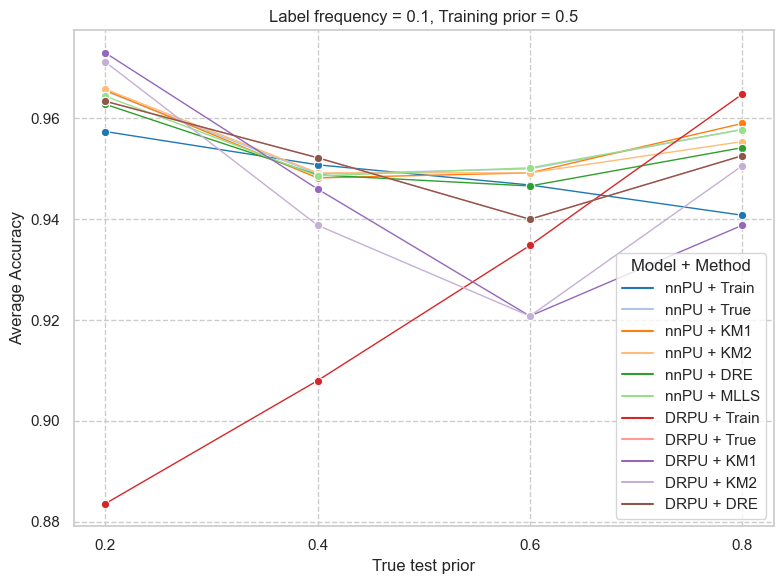

In [24]:
# filter out MLLS
df = df[~df['model-method'].str.contains('DRPU \+ MLLS')]

# MAE of test prior estimates for different training priors
df = df.sort_values(['pi', 'new_pi'])

fig = plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab20")

sns.lineplot(
    data=df,
    x="new_pi",
    y="average_value",
    hue="model-method",
    marker="o",
    markersize=6,
    linestyle="-",
    linewidth=1,
    ax=plt.gca(),
    palette=palette
)

plt.xticks([0.2, 0.4, 0.6, 0.8])
plt.gca().yaxis.grid(True, linestyle='--')
plt.gca().xaxis.grid(True, linestyle='--')

plt.xlabel("True test prior")
plt.ylabel("Average Accuracy")
plt.title("Label frequency = 0.1, Training prior = 0.5")
plt.tight_layout()
plt.legend(title="Model + Method", loc='lower right')
plt.show()

### all data

In [17]:
label_frequencies=[0.1, 0.25]

df = evaluate_shifted_pi_estimation_from_all_data(
    dataset_name='FashionMNIST',
    mean=None,
    label_frequencies=label_frequencies,
    convert_to_df=True,
)

method_mapping = {"dre": "DRE", "km1": "KM1", "km2": "KM2", "mlls_drpu": "MLLS-DRPU", "mlls_nnpu": "MLLS-nnPU", "true": "true" }
df['method'] = df['method'].map(method_mapping)

true_pi = df[df['method'] == 'true'].iloc[0]['estimated_test_pi']
df['mae'] = abs(df['estimated_test_pi'] - true_pi)
df = df[df['method'] != 'true']
df['mae'] = df['mae'].round(3)
df.pivot(index=["label_frequency"], columns="method", values="mae")
# fig = plt.figure(figsize=(8, 6))
# sns.set_theme(style="whitegrid")
# palette = sns.color_palette("tab20")
# sns.lineplot(
#     data=df,
#     x="label_frequency",
#     y="mae",
#     hue="method",
#     marker="o",
#     markersize=6,
#     linestyle="-",
#     linewidth=1,
#     ax=plt.gca(),
#     palette=palette
# )

# plt.xticks(label_frequencies)
# plt.gca().yaxis.grid(True, linestyle='--')
# plt.gca().xaxis.grid(True, linestyle='--')

# plt.xlabel("Label Frequency")
# plt.ylabel("MAE")
# plt.title(f"True test prior = {true_pi.round(2)}")
# plt.tight_layout()
# plt.legend(title="Method", loc='upper right')
# plt.show()

method,DRE,KM1,KM2,MLLS-DRPU,MLLS-nnPU
label_frequency,,,,,
0.10,0.130,0.015,0.013,0.499,0.012
0.25,0.155,0.022,0.019,0.499,0.019


In [20]:
label_frequencies=[0.1, 0.25]

df = evaluate_all_TC_metrics_from_all_data(
    dataset_name='ChestXRay',
    mean=None,
    label_frequencies=label_frequencies,
    convert_to_df=True,
)

df = df[df['metric'].isin(['accuracy'])]

# filter out model = 'nnpu' and method = 'mlls-drpu' or model = 'drpu' and method = 'mlls-nnpu'
df = df[~((df['model'] == 'nnpu') & (df['method'] == 'mlls-drpu')) & ~((df['model'] == 'drpu') & (df['method'] == 'mlls-nnpu'))]

model_mapping = {"drpu": "DRPU", "nnpu": "nnPU"}
method_mapping = {"DR": "DRE", "KM1": "KM1", "KM2": "KM2", "mlls-drpu": "MLLS", "mlls-nnpu": "MLLS", "train": "Train", "true": "True"}
df['model'] = df['model'].map(model_mapping)
df['method'] = df['method'].map(method_mapping)
df['model-method'] = df['model'] + ' + ' + df['method']
df['average_value'] = df['average_value'].round(3)
df.pivot(index=["label_frequency"], columns="model-method", values="average_value")

model-method,DRPU + DRE,DRPU + KM1,DRPU + KM2,DRPU + MLLS,DRPU + Train,DRPU + True,nnPU + DRE,nnPU + KM1,nnPU + KM2,nnPU + MLLS,nnPU + Train,nnPU + True
label_frequency,,,,,,,,,,,,
0.10,0.639,0.686,0.605,0.399,0.761,0.639,0.595,0.773,0.469,0.294,0.895,0.895
0.25,0.668,0.734,0.741,0.402,0.821,0.668,0.586,0.826,0.840,0.294,0.928,0.921


## Chest X Ray

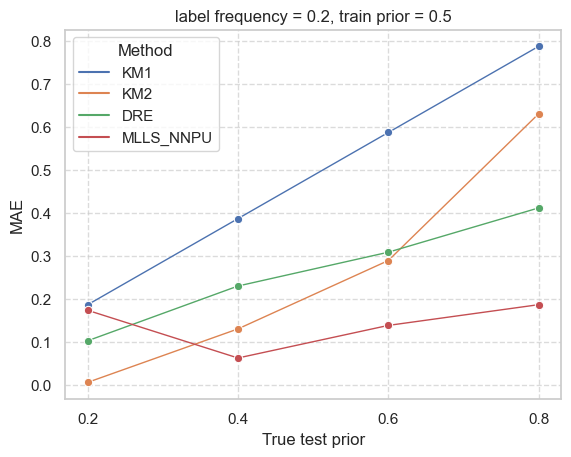

In [27]:
dataset_name = 'ChestXRay'
n = 2_475
label_frequency = 0.2
train_pi = [0.5]
test_pi = [0.2, 0.4, 0.6, 0.8]

df = evaluate_shifted_pi_estimation(dataset_name, None, n, label_frequency, train_pi, test_pi, convert_to_df=True, single_exp=True)
df['mae'] = abs(df['estimated_test_pi'] - df['new_pi'])
# df.pivot(index=["pi", "new_pi"], columns="method", values="mae")

df = df[~(df['method'].isin(['MLLS_DRPU']))]

sns.set_theme(style="whitegrid")
sns.lineplot(
    data=df,
    x="new_pi",
    y="mae",
    hue="method",
    marker="o",
    markersize=6,
    linestyle="-",
    linewidth=1,
)
plt.xticks(test_pi)
plt.xlabel("True test prior")
plt.ylabel("MAE")
plt.title(f"label frequency = {label_frequency}, train prior = 0.5")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Method", loc='upper left')
plt.show()

In [28]:
dataset_name = 'ChestXRay'
n = 2_475
label_frequency = 0.2
train_pi = [0.5]
test_pi = [0.2, 0.4, 0.6, 0.8]

df = evaluate_all_TC_metrics(dataset_name, None, n, label_frequency, train_pi, test_pi, convert_to_df=True, single_exp=True)
df = df[df['metric'].isin(['accuracy'])]

# filter out model = 'nnpu' and method = 'mlls-drpu' or model = 'drpu' and method = 'mlls-nnpu'
df = df[~((df['model'] == 'nnpu') & (df['method'] == 'mlls-drpu')) & ~((df['model'] == 'drpu') & (df['method'] == 'mlls-nnpu'))]

model_mapping = {"drpu": "DRPU", "nnpu": "nnPU"}
method_mapping = {"DR": "DRE", "KM1": "KM1", "KM2": "KM2", "mlls-drpu": "MLLS", "mlls-nnpu": "MLLS", "train": "Train", "true": "True"}
df['model'] = df['model'].map(model_mapping)
df['method'] = df['method'].map(method_mapping)
df['model-method'] = df['model'] + ' + ' + df['method']
df.pivot(index=["pi", "new_pi"], columns="model-method", values="average_value")

model-method  DRPU + DRE  DRPU + KM1  DRPU + KM2  DRPU + MLLS  DRPU + Train   
pi  new_pi                                                                    
0.5 0.2            0.845       0.805       0.885        0.850         0.940  \
    0.4            0.690       0.615       0.770        0.870         0.865   
    0.6            0.665       0.435       0.670        0.890         0.790   
    0.8            0.650       0.245       0.360        0.925         0.745   

model-method  DRPU + True  nnPU + DRE  nnPU + KM1  nnPU + KM2  nnPU + MLLS   
pi  new_pi                                                                   
0.5 0.2             0.845       0.800         0.8       0.830         0.80  \
    0.4             0.690       0.610         0.6       0.765         0.84   
    0.6             0.665       0.665         0.4       0.735         0.75   
    0.8             0.650       0.830         0.2       0.215         0.80   

model-method  nnPU + Train  nnPU + True  
pi  new_pi                               
0.5 0.2              0.880        0.825  
    0.4              0.885        0.885  
    0.6              0.890        0.860  
    0.8              0.925        0.825

C:\Users\izate\AppData\Local\Temp\ipykernel_1184120\379621415.py:11: UserWarning: The palette list has more values (20) than needed (11), which may not be intended.
  sns.lineplot(


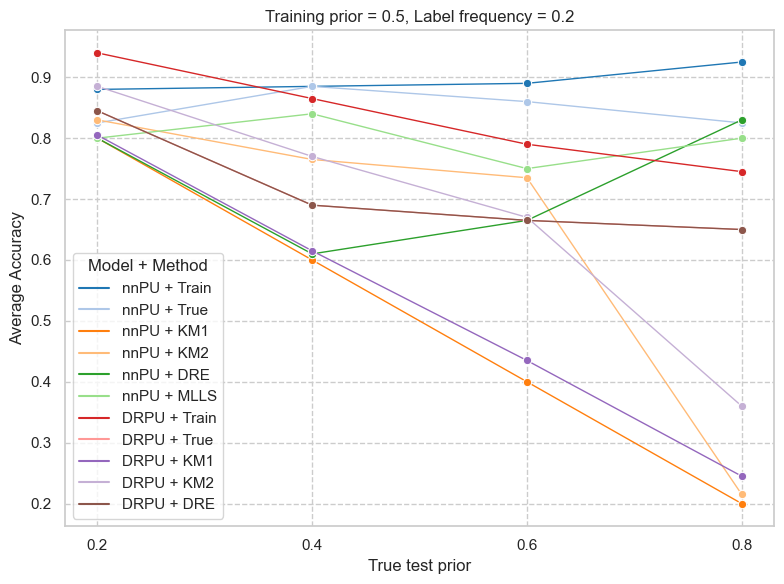

In [31]:
# filter out MLLS
df = df[~df['model-method'].str.contains('DRPU \+ MLLS')]

# MAE of test prior estimates for different training priors
df = df.sort_values(['pi', 'new_pi'])

fig = plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab20")

sns.lineplot(
    data=df,
    x="new_pi",
    y="average_value",
    hue="model-method",
    marker="o",
    markersize=6,
    linestyle="-",
    linewidth=1,
    ax=plt.gca(),
    palette=palette
)

plt.xticks([0.2, 0.4, 0.6, 0.8])
plt.gca().yaxis.grid(True, linestyle='--')
plt.gca().xaxis.grid(True, linestyle='--')

plt.xlabel("True test prior")
plt.ylabel("Average Accuracy")
plt.title("Training prior = 0.5, Label frequency = 0.2")
plt.tight_layout()
plt.legend(title="Model + Method", loc='lower left')
plt.show()

### all data

C:\Users\izate\AppData\Local\Temp\ipykernel_1014792\372237869.py:18: UserWarning: The palette list has more values (20) than needed (5), which may not be intended.
  sns.lineplot(


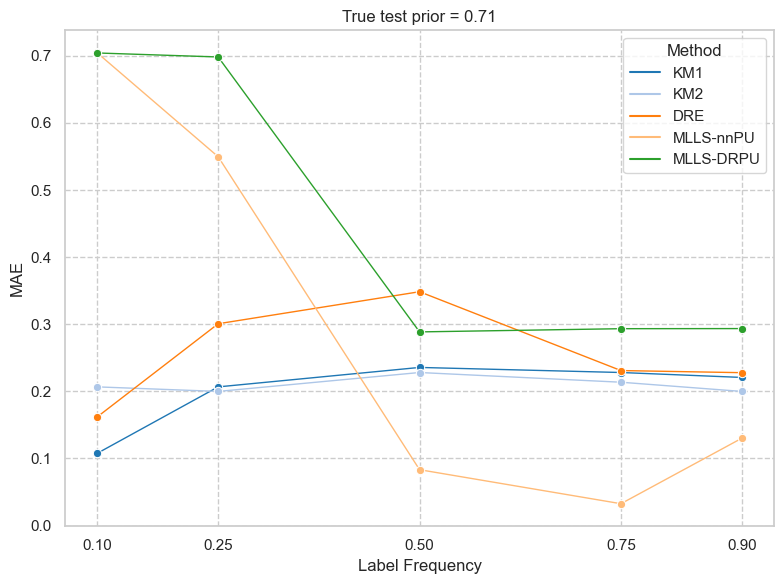

In [4]:
df = evaluate_shifted_pi_estimation_from_all_data(
    dataset_name='ChestXRay',
    mean=None,
    label_frequencies=[0.1, 0.25, 0.5, 0.75, 0.9],
    convert_to_df=True,
)

method_mapping = {"dre": "DRE", "km1": "KM1", "km2": "KM2", "mlls_drpu": "MLLS-DRPU", "mlls_nnpu": "MLLS-nnPU", "true": "true" }
df['method'] = df['method'].map(method_mapping)

true_pi = df[df['method'] == 'true'].iloc[0]['estimated_test_pi']
df['mae'] = abs(df['estimated_test_pi'] - true_pi)
df = df[df['method'] != 'true']

fig = plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab20")
sns.lineplot(
    data=df,
    x="label_frequency",
    y="mae",
    hue="method",
    marker="o",
    markersize=6,
    linestyle="-",
    linewidth=1,
    ax=plt.gca(),
    palette=palette
)

plt.xticks([0.1, 0.25, 0.5, 0.75, 0.9])
plt.gca().yaxis.grid(True, linestyle='--')
plt.gca().xaxis.grid(True, linestyle='--')

plt.xlabel("Label Frequency")
plt.ylabel("MAE")
plt.title(f"True test prior = {true_pi.round(2)}")
plt.tight_layout()
plt.legend(title="Method", loc='upper right')
plt.show()

In [5]:
label_frequencies=[0.1, 0.25, 0.5, 0.75, 0.9]

df = evaluate_all_TC_metrics_from_all_data(
    dataset_name='ChestXRay',
    mean=None,
    label_frequencies=label_frequencies,
    convert_to_df=True,
)

df = df[df['metric'].isin(['accuracy'])]

# filter out model = 'nnpu' and method = 'mlls-drpu' or model = 'drpu' and method = 'mlls-nnpu'
df = df[~((df['model'] == 'nnpu') & (df['method'] == 'mlls-drpu')) & ~((df['model'] == 'drpu') & (df['method'] == 'mlls-nnpu'))]

model_mapping = {"drpu": "DRPU", "nnpu": "nnPU"}
method_mapping = {"DR": "DRE", "KM1": "KM1", "KM2": "KM2", "mlls-drpu": "MLLS", "mlls-nnpu": "MLLS", "train": "Train", "true": "True"}
df['model'] = df['model'].map(model_mapping)
df['method'] = df['method'].map(method_mapping)
df['model-method'] = df['model'] + ' + ' + df['method']
df.pivot(index=["label_frequency"], columns="model-method", values="average_value")

model-method,DRPU + DRE,DRPU + KM1,DRPU + KM2,DRPU + MLLS,DRPU + Train,DRPU + True,nnPU + DRE,nnPU + KM1,nnPU + KM2,nnPU + MLLS,nnPU + Train,nnPU + True
label_frequency,,,,,,,,,,,,
0.10,0.639175,0.685567,0.604811,0.398625,0.761168,0.639175,0.594502,0.773196,0.469072,0.293814,0.895189,0.895189
0.25,0.668385,0.733677,0.740550,0.402062,0.821306,0.668385,0.585911,0.826460,0.840206,0.293814,0.927835,0.920962
0.50,0.766323,0.847079,0.853952,0.922680,0.890034,0.766323,0.850515,0.932990,0.936426,0.929553,0.931271,0.927835
0.75,0.902062,0.903780,0.907216,0.926117,0.879725,0.902062,0.932990,0.932990,0.934708,0.917526,0.939863,0.927835
0.90,0.898625,0.900344,0.903780,0.931271,0.546392,0.898625,0.936426,0.936426,0.936426,0.857388,0.934708,0.902062


C:\Users\izate\AppData\Local\Temp\ipykernel_1184120\3644213849.py:4: UserWarning: The palette list has more values (20) than needed (12), which may not be intended.
  sns.lineplot(


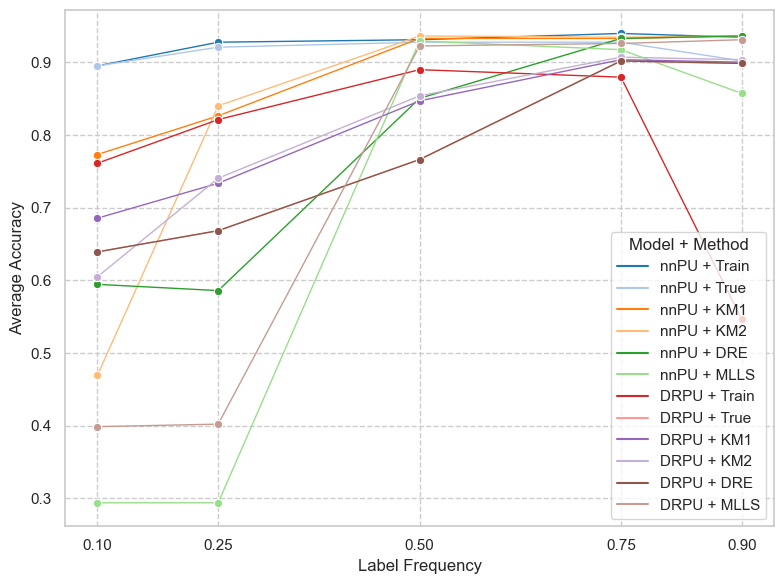

In [11]:
fig = plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab20")
sns.lineplot(
    data=df,
    x="label_frequency",
    y="average_value",
    hue="model-method",
    marker="o",
    markersize=6,
    linestyle="-",
    linewidth=1,
    ax=plt.gca(),
    palette=palette
)

plt.xticks([0.1, 0.25, 0.5, 0.75, 0.9])
plt.gca().yaxis.grid(True, linestyle='--')
plt.gca().xaxis.grid(True, linestyle='--')

plt.xlabel("Label Frequency")
plt.ylabel("Average Accuracy")
# plt.title(f"True test prior = {true_pi.round(2)}")
plt.tight_layout()
plt.legend(title="Model + Method", loc='lower right')
plt.show()

In [13]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# for method in df["method"].unique():
#     df_method = df[df["method"] == method]
#     plt.figure(figsize=(6, 4))
#     plt.title(f"Estimated pi ({method})")
#     sns.heatmap(df_method.pivot(index="pi", columns="new_pi", values="mean"), annot=True, fmt=".2f", 
#         cmap= "PiYG",
#         vmin= min(df_method["mean"]),
#         vmax= max(df_method["mean"]),
#         center=0)
#     plt.show()